In [7]:
import sys
import os
sys.path.append("/home/reshetnikov/asbest/asbestos/")
# sys.path.append("/home/kirilman/Project/asbestos/")
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import cv2
import seaborn as sns
%matplotlib inline
from dataset.path_utils import get_files_from_dirs, get_paths_from_dirs
from pycocotools.coco import COCO
import pandas as pd
from dataset import load_txt
from yolov5.utils.general import xywhn2xyxy, xywh2xyxy, xyxy2xywh
from dataset.plot_utils import plot_masks
import torch
from PIL import Image
import matplotlib.patches as patches

In [8]:
!pwd

/home/reshetnikov/asbest/asbestos/notebooks/Statistical test


In [9]:
# model = torch.load('../../yolov5/runs/train/albumentation_5m6/weights/best.pt')

In [10]:
def get_diag(coords):
    if isinstance(coords, np.ndarray) and len(coords.shape) == 2:
        x1 = coords[0,0]
        y1 = coords[0,1]
        x2 = coords[0,2]
        y2 = coords[0,3]
    else:
        x1,y1,x2,y2 = coords
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def distance(p1,p2):
    x0 = p1[0] - p2[0]
    y0 = p1[1] - p2[1]
    return np.sqrt(x0 ** 2 + y0 ** 2)

def get_ann(ann_pth):
    with open(ann_pth, 'r') as f:
        data = f.read()
    return [list(map(float, string.split(' '))) for string in data.split('\n') if len(string) > 0]

def yolo2coco(xc, yc, w, h, image_width, image_height):
    xc, w = xc*image_width,  w*image_width
    yc, h = yc*image_height, h*image_height
    xmin = xc - w//2
    ymin = yc - h//2
    return xmin,ymin,w, h

def plot_bbox(image_pth, ann_pth = None):
    image =  np.asarray(Image.open(image_pth))

    height, width = image.shape[:2]

    if ann_pth is None:
        ann_pth = os.path.splitext(image_pth)[0]+'.txt'
        
    bbox   = np.asarray(get_ann(ann_pth))[:,1:]

    fig, axs = plt.subplots(1, 2, figsize = (8,4))
    image_ = np.copy(image).astype(float)/image.max()
    
    # Ground Truth    
    axs[0].imshow(np.clip(image_,0,1), 'gray')
    axs[0].axis('off'); axs[0].set_title('Original Image')
    #----------------------------
    
    # Object Detection BBoxes
    axs[1].imshow(np.clip(image_,0,1), 'gray')
    for box in bbox:
        xmin,ymin,w,h = yolo2coco(*box, width,height)
        bb = patches.Rectangle(xy     = (xmin,ymin), 
                               width  = w,height = h, 
                               linewidth=2, edgecolor="blue", facecolor="none")
        axs[1].add_patch(bb)  
    axs[1].axis('off'); axs[1].set_title('Object Detection')

    plt.tight_layout()
    plt.show()
    
def get_metric_from_dir(p,fun_metric, need_names):
    if isinstance(p, str):
        p = Path(p)
    files = list((p.glob("*.txt")))
    files = list(filter(lambda x: True if x.name.split('.')[0] in need_names else False, files))
    diags = []
    for f in files:
        labels = np.loadtxt(f)
        if len(labels.shape) == 1:
            labels = labels.reshape(1,-1)
        if labels.shape[1] == 6:
            labels = labels[:,[1,2,3,4]]
        elif labels.shape[1] == 5:
            labels = labels[:,1:]
        for i,c in enumerate(xywh2xyxy(labels)):
            diags.append(fun_metric(c))
    return diags

In [133]:
segment_files = get_paths_from_dirs(['../../../dataset/annotation/'],['json'])
print(len(segment_files))
segment_files[5]

10


PosixPath('../../../dataset/annotation/pits_stones_detections_161220/instances_default.json')

In [134]:
coco = COCO(segment_files[2])
frame = pd.DataFrame(coco.anns).T
frame

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


,id,image_id,category_id,segmentation,area,bbox,iscrowd,attributes
1,1,1,1,"[[213.4, 1386.69, 145.72, 1392.11, 114.13, 138...",18025.0,"[109.62, 1255.84, 216.59, 136.27]",0,{'occluded': False}
2,2,1,1,"[[635.12, 1788.38, 648.66, 1836.21, 673.93, 18...",30871.0,"[635.12, 1774.84, 288.79, 160.64]",0,{'occluded': False}
3,3,1,1,"[[504.27, 1868.7, 508.89, 1850.8, 529.54, 1838...",15050.0,"[504.27, 1838.92, 176.88, 151.61]",0,{'occluded': False}
4,4,1,1,"[[901.14, 1759.75, 966.12, 1775.35, 1003.81, 1...",25472.0,"[804.98, 1571.32, 224.82, 204.03]",0,{'occluded': False}
5,5,1,1,"[[727.0, 1979.38, 776.39, 2002.77, 795.88, 201...",8191.0,"[704.91, 1919.6, 132.56, 94.86]",0,{'occluded': False}
...,...,...,...,...,...,...,...,...
720,720,13,1,"[[1225.95, 1100.26, 1230.3, 1122.46, 1251.63, ...",3731.0,"[1225.52, 1073.71, 97.05, 65.29]",0,{'occluded': False}
721,721,13,1,"[[1113.59, 1012.91, 1125.19, 1015.81, 1150.58,...",4969.0,"[1107.06, 940.01, 83.78, 84.87]",0,{'occluded': False}
722,722,13,1,"[[1100.17, 985.71, 1104.88, 998.76, 1099.8, 10...",3087.0,"[1031.98, 975.91, 72.9, 62.38]",0,{'occluded': False}
723,723,13,1,"[[975.01, 1200.59, 1013.81, 1197.69, 1026.51, ...",9170.0,"[953.25, 1137.85, 160.3, 95.75]",0,{'occluded': False}


In [135]:
np.array(frame.bbox.values[0])[[0,1,2]]

array([     109.62,      1255.8,      216.59])

In [136]:
df_image = pd.DataFrame(coco.imgs).T
image_names = [p.split('/')[-1].split('.')[0] for p in list(df_image.file_name)]

In [137]:
IMAGE_W = df_image.iloc[0]['width']
IMAGE_H = df_image.iloc[0]['height']
print(IMAGE_W, IMAGE_H)
df_image
path_2_label= '/home/kirilman/Project/asbestos/yolov5/runs/detect/exp9/labels/'

2592 2048


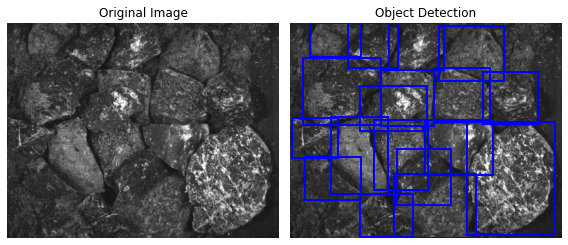

In [138]:
image_pth = '../../../dataset/detection_set2/images/1_11_32_12_16-03-2020_1.jpg'
ann_pth   = os.path.splitext(image_pth.replace('images','labels'))[0] + '.txt'
plot_bbox(image_pth,ann_pth)

In [139]:
segments = frame.segmentation.values
arr_maxd = np.zeros((len(segments)))
for i,segment in enumerate(segments):
    x_coords = segment[0][::2]
    y_coords = segment[0][1::2]
    Points = [(x/IMAGE_H,y/IMAGE_W) for x,y in zip(x_coords, y_coords)]
    max_d = 0
    for p1 in Points:
        for p2 in Points:
            max_d = max(max_d, distance(p1,p2))
            # print(max_d)
    arr_maxd[i] = max_d
print(len(arr_maxd))

724


In [140]:
labels_files = get_paths_from_dirs(['../../yolov7/runs/detect/exp6/labels/'],['*'])
labels_files = get_paths_from_dirs([path_2_label],['*'])

diags = []
for p in labels_files:
    if p.name.split('.')[0] in image_names:
        data = np.loadtxt(p)
        bboxs = data[:,1:]
        for i,box in enumerate(xywh2xyxy(bboxs)):
            diags.append(get_diag(box))
print(len(diags),'img: ', len(image_names))

994 img:  13


In [141]:
# diags = get_metric_from_dir(path_2_label, get_diag, image_names

<AxesSubplot:ylabel='Count'>

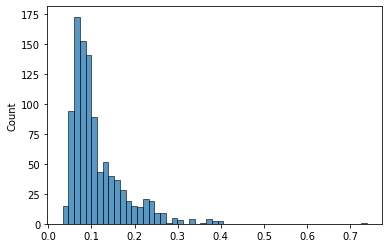

In [142]:
sns.histplot(np.array(diags))

Text(0.5, 1.0, '')

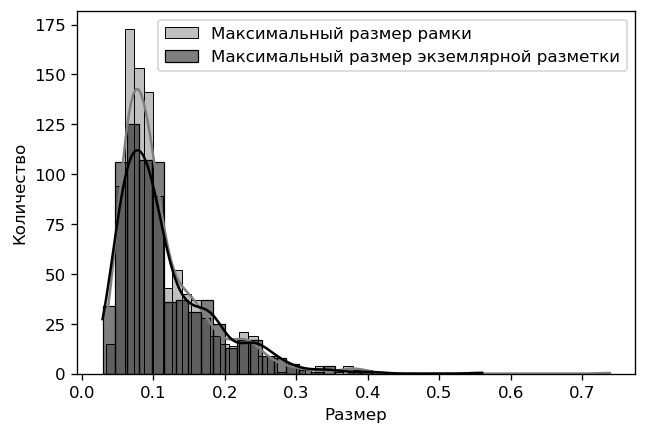

In [143]:
fig = plt.figure(dpi = 120)
ax = sns.histplot(diags,color= 'grey',kde = True,  label = 'Максимальный размер рамки',)
ax = sns.histplot(arr_maxd, color = 'black',kde = True, label = 'Максимальный размер экземлярной разметки', )
ax.legend(loc = 1)
plt.xlabel("Размер")
plt.ylabel("Количество")
plt.title("")


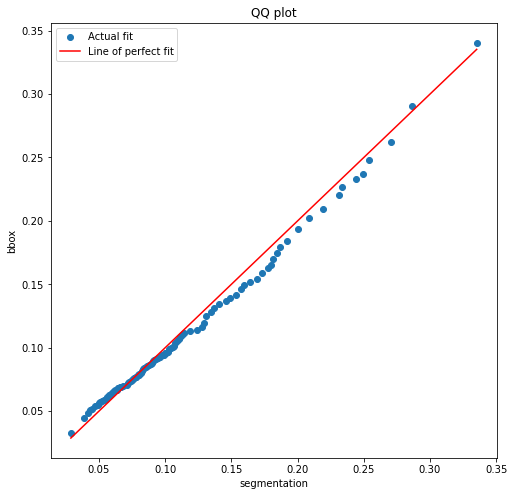

In [153]:
df_pct = pd.DataFrame()
df_pct['segmentation'] = np.percentile(arr_maxd, range(100))
df_pct['bbox'] = np.percentile(diags, range(100))

plt.figure(figsize=(8, 8))
plt.scatter(x='segmentation', y='bbox', data=df_pct, label='Actual fit');
sns.lineplot(x='segmentation', y='segmentation', data=df_pct, color='r', label='Line of perfect fit');
plt.xlabel('segmentation')
plt.ylabel('bbox')
plt.legend()
plt.title("QQ plot");

In [29]:
def plot_ecfplot(bbox_size, instance_size, dataset_name):
    fig = plt.figure(dpi = 150)
    ax = sns.ecdfplot(bbox_size, color='gray', linestyle = '--' , label = 'Максимальный размер рамки', lw=2 , )
    ax = sns.ecdfplot(instance_size, color='black', label = 'Максимальный размер экземлярной разметки', lw=2 )
    ax.legend(loc = 4)
    plt.xlabel("Размер")
    plt.ylabel("Вероятность")
    plt.title("")
    plt.xlim(0,1)
    plt.savefig(dataset_name + '.jpg')
    plt.grid()
    
def plot_hist(bbox_size, instance_size, dataset_name):
    fig = plt.figure(dpi = 120)
    ax = sns.histplot(bbox_size,color= 'grey',kde = True,  label = 'Максимальный размер рамки',)
    ax = sns.histplot(instance_size, color = 'black',kde = True, label = 'Максимальный размер экземлярной разметки', )
    ax.legend(loc = 1)
    plt.xlabel("Размер")
    plt.ylabel("Количество")
    plt.title("")
    plt.savefig('hist_' + dataset_name + '.jpg')


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
2592 2048
Количество instance labels  718
BBoxs : 1024 img:  11
../../../dataset/annotation/pits_stones_detections_300920

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
2592 2048
Количество instance labels  1521
BBoxs : 359 img:  57
../../../dataset/annotation/asbestos_stone_161220

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
2592 2048
Количество instance labels  724
BBoxs : 1236 img:  13
../../../dataset/annotation/pits_stones_detections_020221

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
2592 2048
Количество instance labels  4531
BBoxs : 7846 img:  68
../../../dataset/annotation/pits_stones_detections_161120

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
2592 2048
Количество instance labels  245
BBoxs : 232 img:  24
../../../dataset/annotation/open-pit-

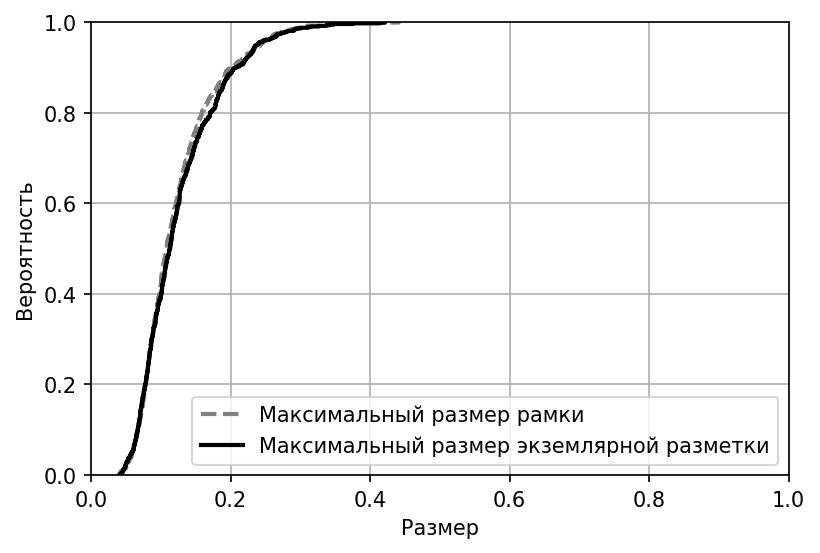

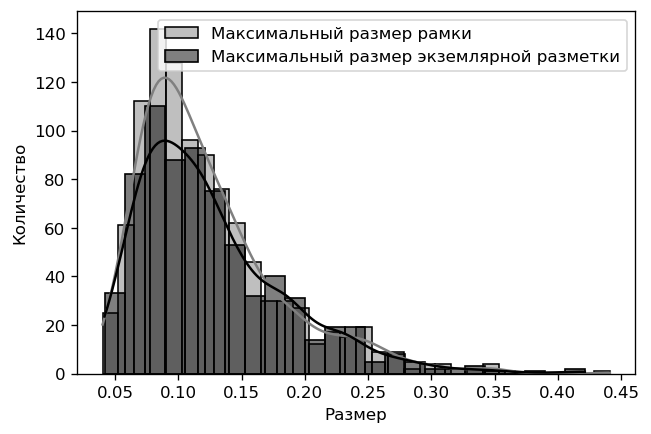

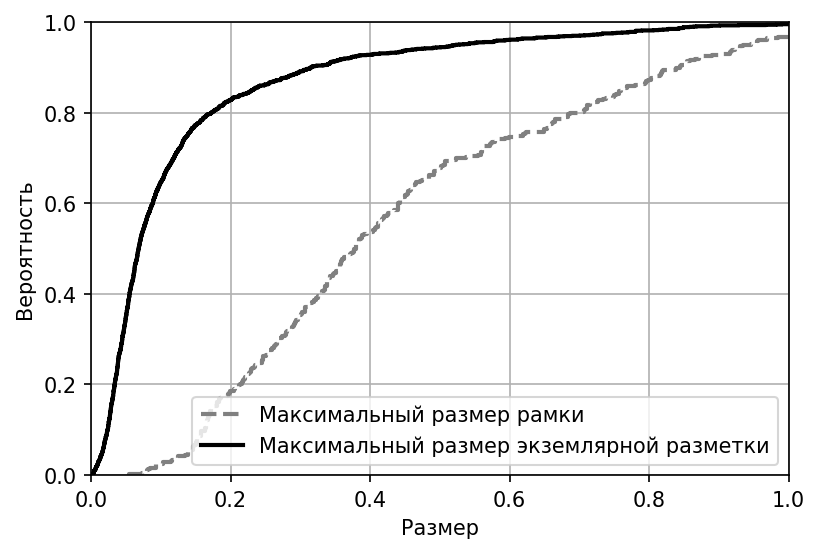

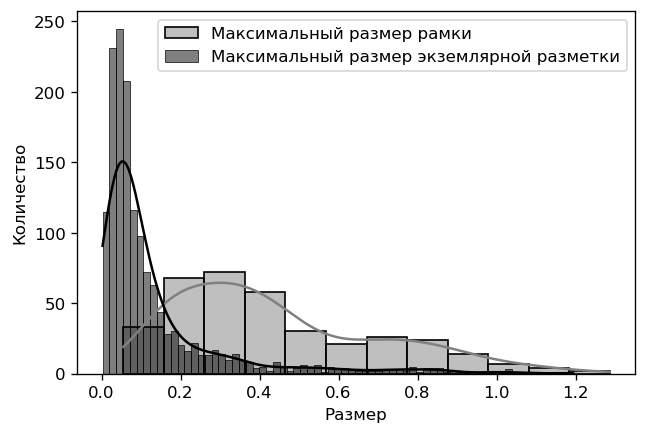

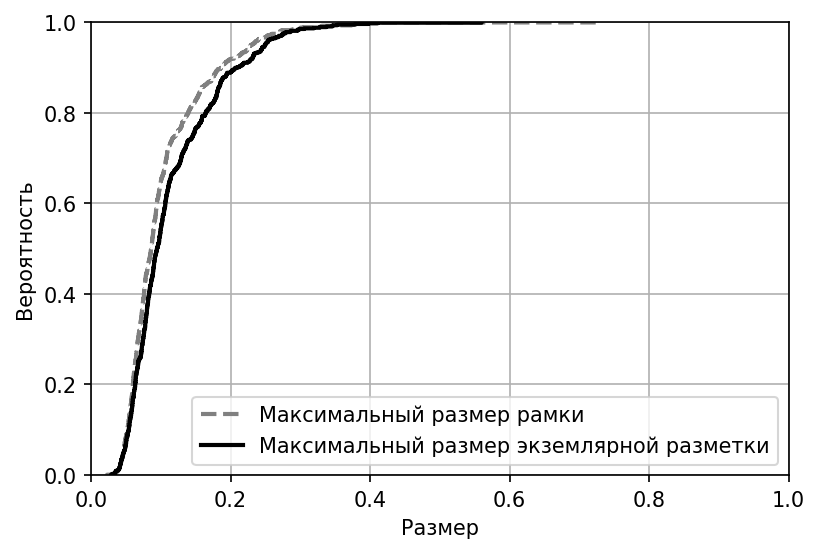

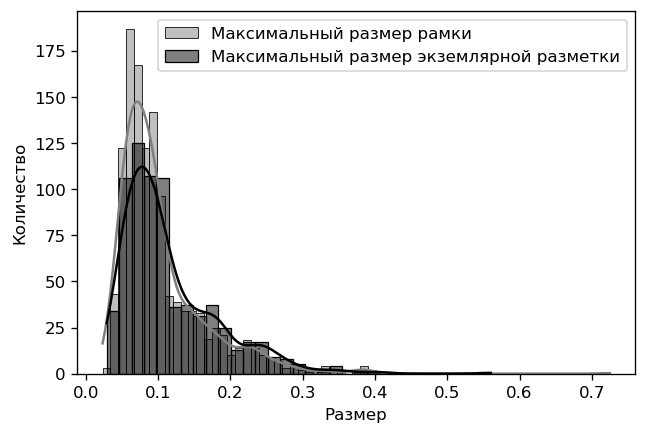

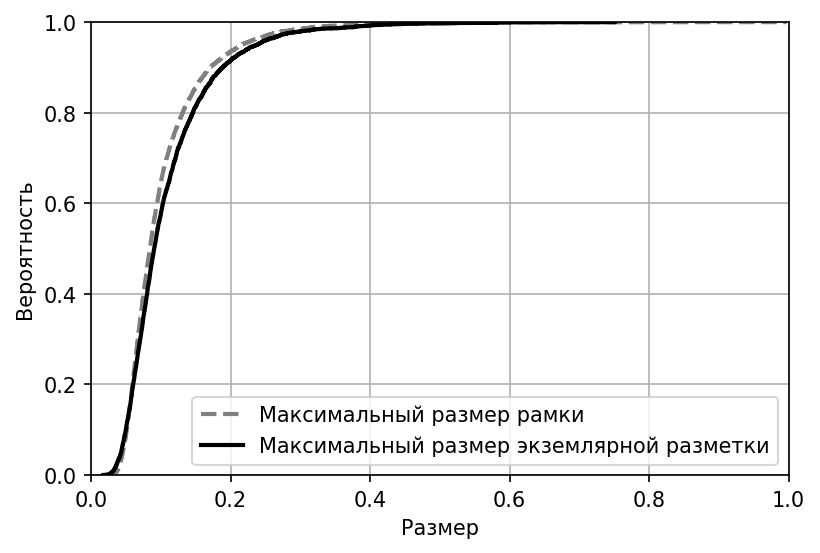

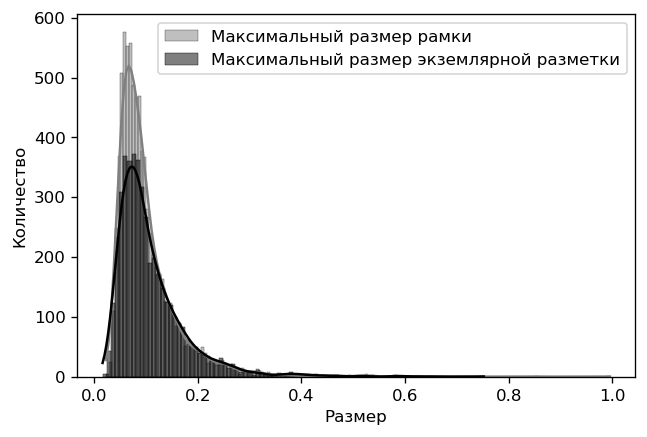

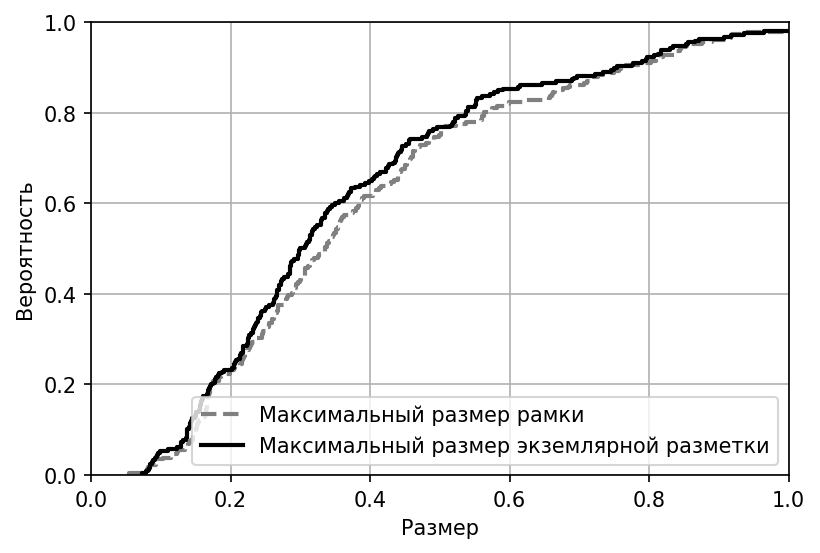

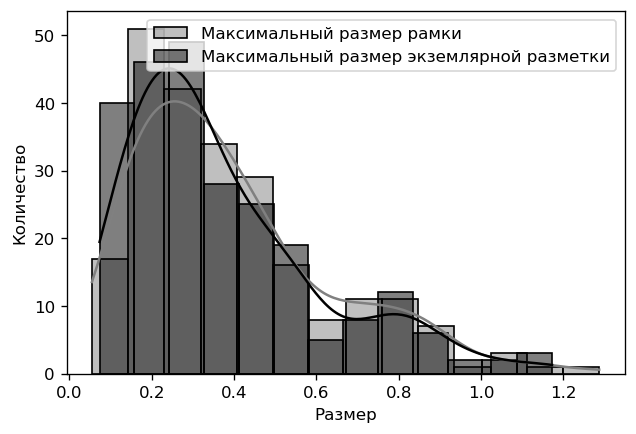

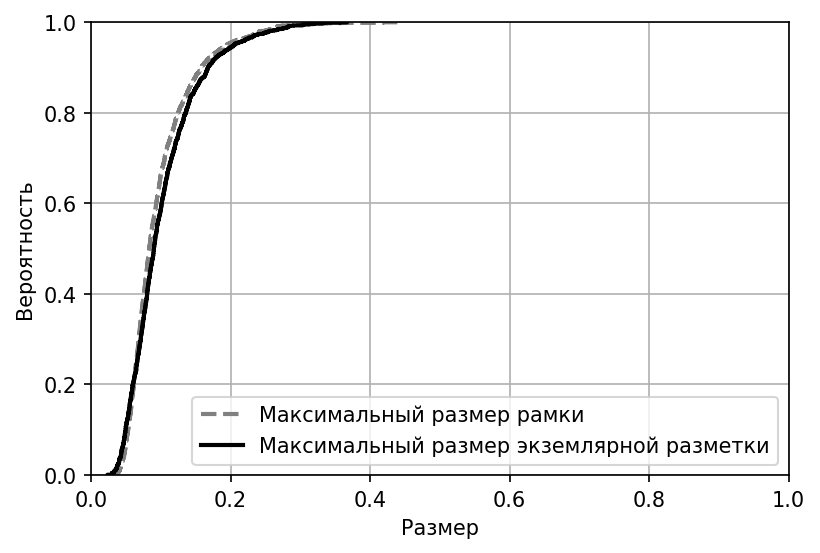

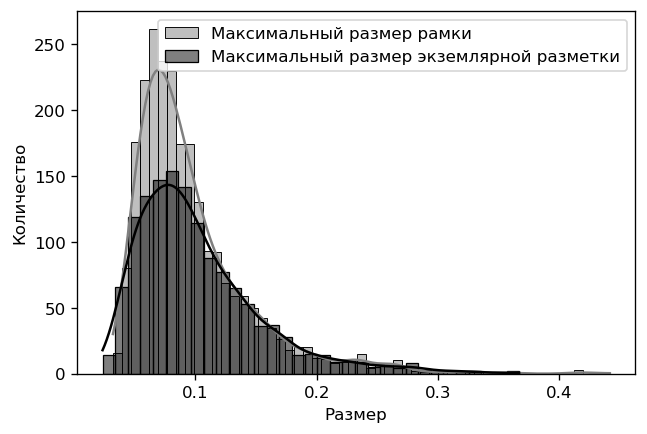

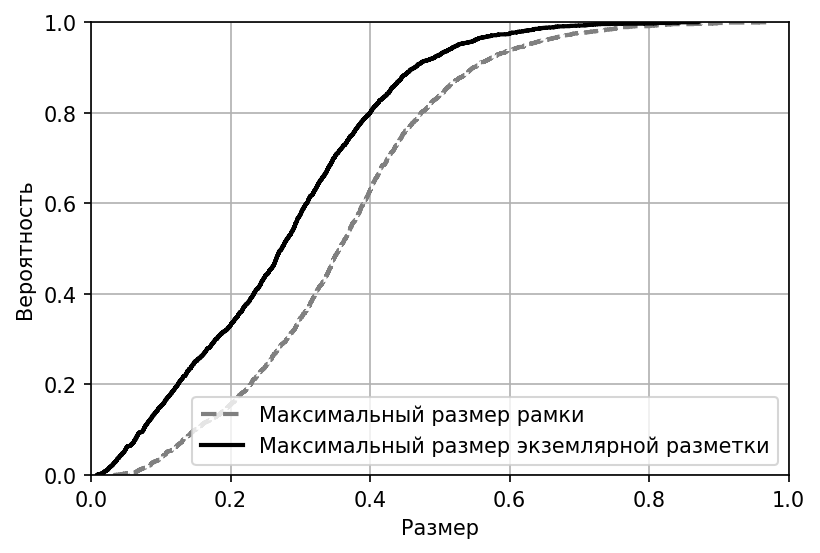

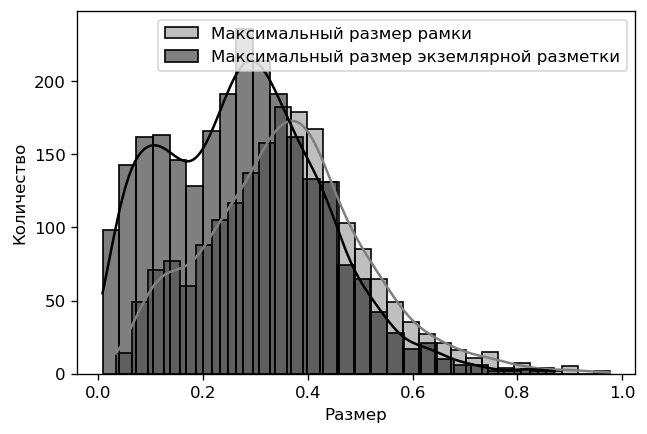

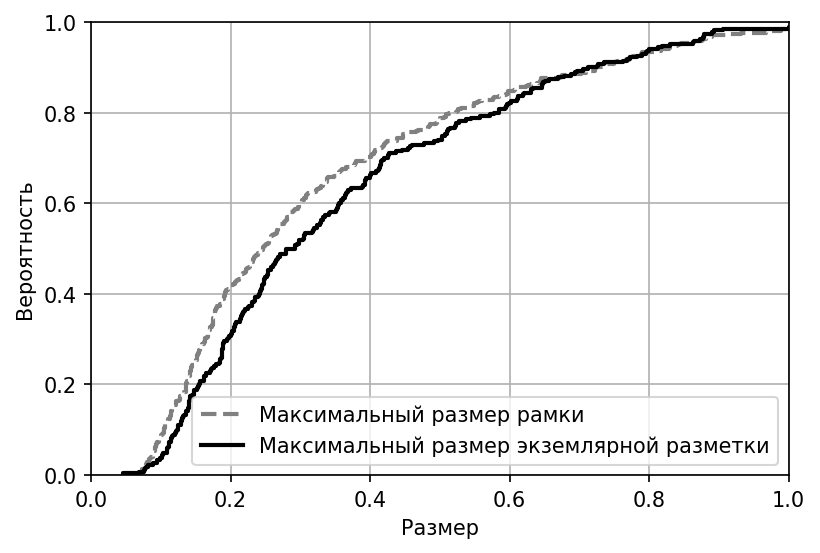

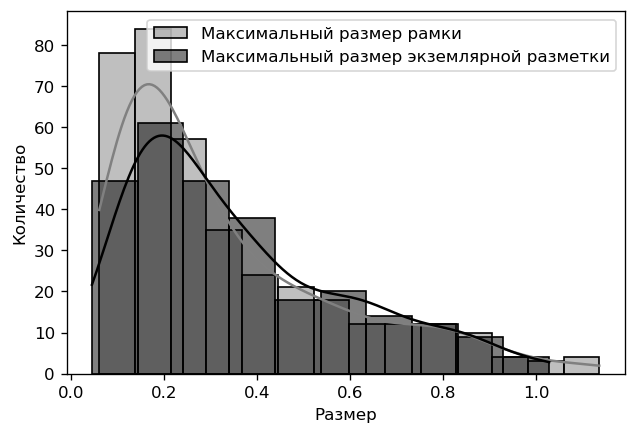

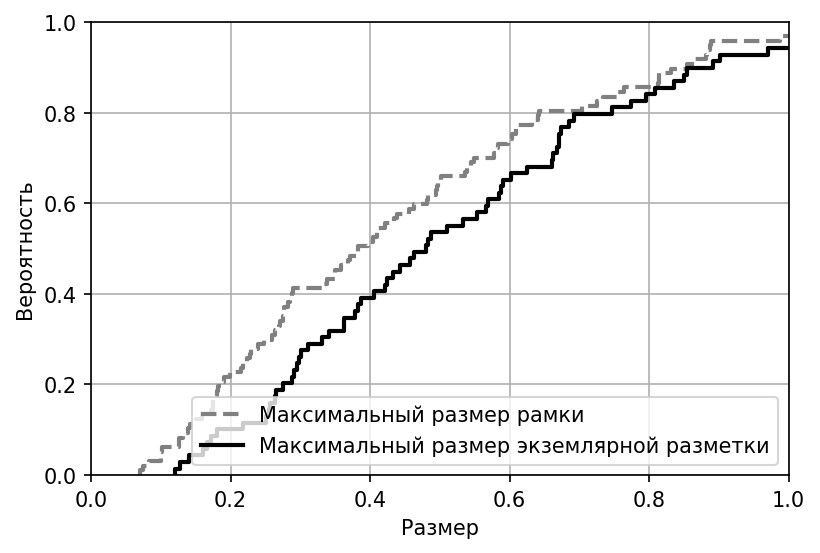

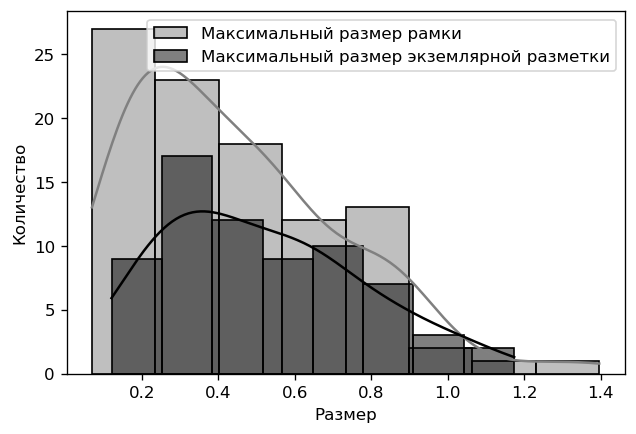

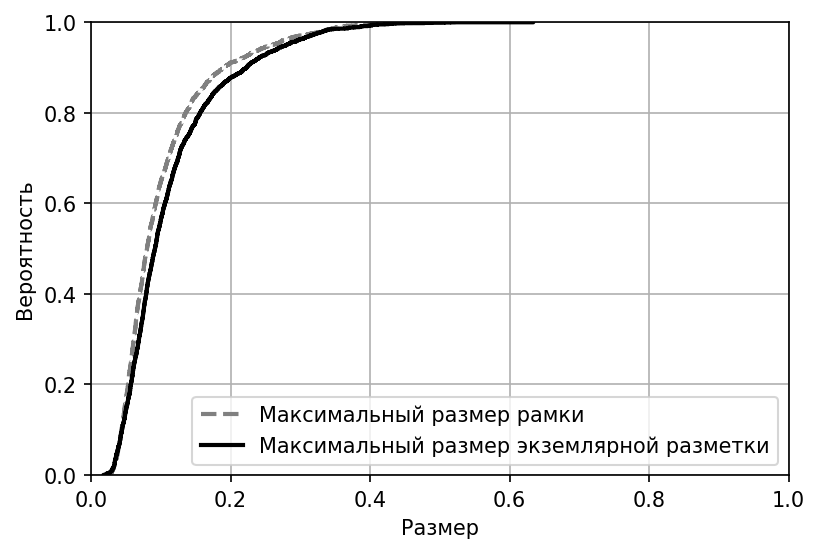

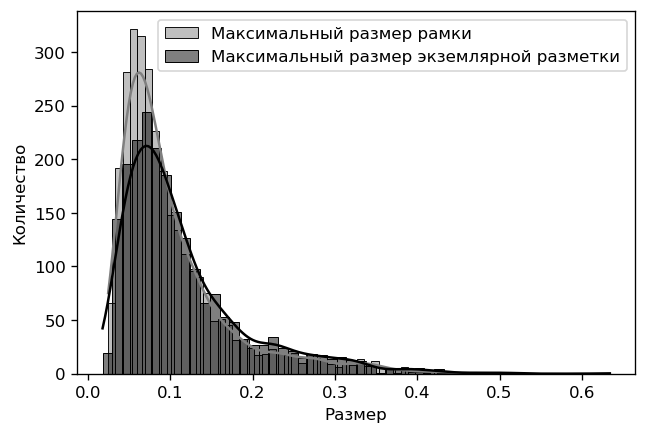

In [5]:
path_2_label= '/home/kirilman/Project/asbestos/yolov5/runs/detect/exp9/labels/'
path_2_label= '/home/kirilman/Project/asbestos/yolov7/runs/detect/exp6/labels/'

# path_2_label= '/home/kirilman/Project/asbestos/YOLOv6/runs/inference/exp/'

for segment_file in get_paths_from_dirs(['../../../dataset/annotation/'],['json']):
    coco = COCO(segment_file);
    frame = pd.DataFrame(coco.anns).T
    df_image = pd.DataFrame(coco.imgs).T
    image_names = [p.split('/')[-1].split('.')[0] for p in list(df_image.file_name)]
    IMAGE_W = df_image.iloc[0]['width']
    IMAGE_H = df_image.iloc[0]['height']
    print(IMAGE_W, IMAGE_H)
    segments = frame.segmentation.values
    
    instance_max_size = np.zeros((len(segments)))
    for i,segment in enumerate(segments):
        x_coords = segment[0][::2]
        y_coords = segment[0][1::2]
        Points = [(x/IMAGE_H,y/IMAGE_W) for x,y in zip(x_coords, y_coords)]
        max_d = 0
        for p1 in Points:
            for p2 in Points:
                max_d = max(max_d, distance(p1,p2))
        instance_max_size[i] = max_d
    print("Количество instance labels ", len(instance_max_size))
    
    
    labels_files = get_paths_from_dirs([path_2_label],['txt'])
    bbox_sizes = []
    for p in labels_files:
        if p.name.split('.')[0] in image_names:
            data = np.loadtxt(p)
            if len(data.shape) > 1:
                bboxs = data[:,1:5]
            else:
                bboxs = data[1:5].reshape(1,-1)
            for i,box in enumerate(xywh2xyxy(bboxs)):
                bbox_sizes.append(get_diag(box))
    print("BBoxs :",len(bbox_sizes),'img: ', len(image_names))
    
    plot_ecfplot(bbox_sizes, instance_max_size, str(segment_file).split('/')[-2])
    plot_hist(bbox_sizes, instance_max_size, str(segment_file).split('/')[-2])

    print(str(segment_file.parent) + '\n')

#### Статистические тесты

In [33]:
import scipy.stats as stats

724 994
Ttest_indResult(statistic=-1.4186151556799305, pvalue=0.15632344460965134)


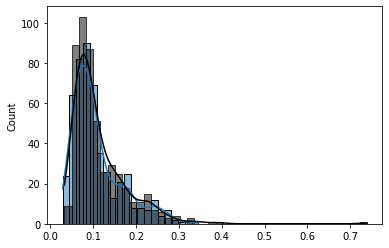

In [154]:
print(len(arr_maxd), len(diags))
res = np.zeros((100))
for i in range(100):
    a = np.random.choice(arr_maxd, 500)
    b = np.random.choice(diags, 500)
    r = stats.ttest_ind(a, b, equal_var = True)
    res[i] = r.statistic
    
sns.histplot(a, kde = True)
sns.histplot(b, kde = True, color = 'black')
print(r)

In [2]:
def max_size(bbox):
    x1,y1,x2,y2 = bbox
    return max(abs(x2-x1), abs(y2-y1))

In [22]:
def get_bbox_size_arr(path_2_label, image_names ):
    labels_files = get_paths_from_dirs([path_2_label],['txt'])
    labels_files = list(filter(lambda x: True if str(x.name).split('.')[0] in image_names else False, labels_files))
    bbox_sizes = []
    for p in labels_files:
        if p.name.split('.')[0] in image_names:
            data = np.loadtxt(p)
            if len(data.shape) > 1:
                bboxs = data[:,1:5]
            else:
                bboxs = data[1:5].reshape(1,-1)
            for i,box in enumerate(xywh2xyxy(bboxs)):
                bbox_sizes.append(get_diag(box))
                # bbox_sizes.append(max_size(box))
    return np.array(bbox_sizes)

def get_instance_max_size(segment_file):
    coco = COCO(segment_file)
    frame = pd.DataFrame(coco.anns).T
    df_image = pd.DataFrame(coco.imgs).T
    image_names = [p.split('/')[-1].split('.')[0] for p in list(df_image.file_name)]
    IMAGE_W = df_image.iloc[0]['width']
    IMAGE_H = df_image.iloc[0]['height']
    print(IMAGE_W, IMAGE_H)
    segments = frame.segmentation.values
    
    instance_max_size = np.zeros((len(segments)))
    for i,segment in enumerate(segments):
        x_coords = segment[0][::2]
        y_coords = segment[0][1::2]
        Points = [(x/IMAGE_H,y/IMAGE_W) for x,y in zip(x_coords, y_coords)]
        max_d = 0
        for p1 in Points:
            for p2 in Points:
                max_d = max(max_d, distance(p1,p2))
        instance_max_size[i] = max_d
    return np.array(instance_max_size), image_names

def get_diag_from_json(segment_file):
    coco = COCO(segment_file)
    frame = pd.DataFrame(coco.anns).T
    df_image = pd.DataFrame(coco.imgs).T
    image_names = [p.split('/')[-1].split('.')[0] for p in list(df_image.file_name)]
    bboxs = frame.bbox.values
    IMAGE_W = df_image.iloc[0]['width']
    IMAGE_H = df_image.iloc[0]['height']
    diag = []
    for bbox in bboxs:
        bbox = np.array(bbox).reshape(1,-1)
        bbox[:,[0,2]] = bbox[:,[0,2]]/IMAGE_H
        bbox[:,[1,3]] = bbox[:,[1,3]]/IMAGE_W
        diag.append(get_diag(xywh2xyxy(bbox)))
    return np.array(diag)

In [23]:
def filter_by_quant(arr):
    qmin = np.quantile(arr, 0.05)
    qmax = np.quantile(arr, 0.95)
    print(arr.shape)
    return arr[np.where( (arr < qmax)*(arr > qmin))]

In [156]:
result = {}
result_median = {}
result_wilcon = {}
result_smirnov = {}
path_2_label= '/home/kirilman/Project/asbestos/yolov5/runs/detect/exp9/labels/'
# path_2_label= '/home/kirilman/Project/asbestos/yolov7/runs/detect/exp6/labels/'

for segment_file in get_paths_from_dirs(['../../../dataset/annotation/'],['json']):
    instance_max_size = get_instance_max_size(segment_file)
    instance_max_size = get_diag_from_json(segment_file)
    # instance_max_size = filter_by_quant(instance_max_size)
    
    print("Количество instance labels ", len(instance_max_size))
    bbox_sizes = get_bbox_size_arr(path_2_label)
    # bbox_sizes = filter_by_quant(bbox_sizes)

    print("BBoxs :",len(bbox_sizes),'img: ', len(image_names))
    r = stats.ttest_ind(instance_max_size, bbox_sizes, equal_var = True)
    result[str(segment_file.parent).split('/')[-1]]= {'value': r.statistic,'pvalue':r.pvalue}
    
    stat, p, med, tbl = stats.median_test(instance_max_size, bbox_sizes)
    result_median[str(segment_file.parent).split('/')[-1]] = {'value': stat,'pvalue': p}
    
    r = stats.kstest(instance_max_size, bbox_sizes)
    result_smirnov[str(segment_file.parent).split('/')[-1]] =  {'value': r.statistic,'pvalue':r.pvalue}
    
    # # plot_hist(bbox_sizes, instance_max_size, str(segment_file).split('/')[-2])
    # plot_ecfplot(bbox_sizes, instance_max_size, str(segment_file).split('/')[-2])

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
2592 2048
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Количество instance labels  718
BBoxs : 1236 img:  13
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
2592 2048
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Количество instance labels  1521
BBoxs : 1236 img:  13
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
2592 2048
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Количество instance labels  724
BBoxs : 1236 img:  13
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
2592 2048
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Количество instance labels  4531
BBoxs : 1236 img:  13
loading annotations into memory...
Done (t=0.01s)
creating index...
index crea

In [124]:
instance_max_size

array([   0.063741,     0.04344,     0.13793, ...,    0.039052,    0.054773,    0.082638])

In [125]:
frame_stat = pd.concat((pd.DataFrame(result).T, pd.DataFrame(result_median).T, pd.DataFrame(result_smirnov).T), axis = 1)
frame_stat.to_csv('yolov5_stat.csv')
np.round(frame_stat,5)

,value,pvalue,value,pvalue,value,pvalue
pits_stones_detections_300920,14.10130,0.0,329.26726,0.00000,0.38511,0.0
asbestos_stone_161220,9.81500,0.0,18.80378,0.00001,0.19306,0.0
pits_stones_detections_020221,9.23602,0.0,139.17544,0.00000,0.24997,0.0
pits_stones_detections_161120,12.31613,0.0,253.11394,0.00000,0.21313,0.0
open-pit-zoomed-161120,48.54934,0.0,262.64644,0.00000,0.78185,0.0
pits_stones_detections_161220,6.39845,0.0,164.63514,0.00000,0.22173,0.0
test transport,59.77612,0.0,1835.78649,0.00000,0.61629,0.0
asbestos_stone_020221,47.14552,0.0,274.94703,0.00000,0.72343,0.0
asbest_stones_111121,47.11215,0.0,68.54006,0.00000,0.84993,0.0
pits_stones_detections_111121,11.60238,0.0,152.81519,0.00000,0.18238,0.0


In [126]:
frame_smirnov = pd.DataFrame(result_smirnov).T
frame_smirnov.sort_values('pvalue', ascending = False)

,value,pvalue
pits_stones_detections_020221,0.249969,1.341093e-32
asbestos_stone_161220,0.193065,1.707068e-33
pits_stones_detections_111121,0.182383,5.787094e-37
pits_stones_detections_161220,0.221729,2.193331e-41
asbest_stones_111121,0.849932,3.072627e-55
pits_stones_detections_161120,0.213126,1.042105e-72
pits_stones_detections_300920,0.385113,1.508297e-77
asbestos_stone_020221,0.723427,2.815753e-130
open-pit-zoomed-161120,0.781854,2.615293e-144
test transport,0.616290,0.000000e+00


In [127]:
np.round(frame_stat.iloc[:,2:4].sort_values('pvalue', ascending = False), 3)

,value,pvalue
asbestos_stone_161220,18.804,0.0
asbest_stones_111121,68.540,0.0
pits_stones_detections_020221,139.175,0.0
pits_stones_detections_111121,152.815,0.0
pits_stones_detections_161220,164.635,0.0
pits_stones_detections_161120,253.114,0.0
open-pit-zoomed-161120,262.646,0.0
asbestos_stone_020221,274.947,0.0
pits_stones_detections_300920,329.267,0.0
test transport,1835.786,0.0


In [697]:
print(path_2_label)
for segment_file in get_paths_from_dirs(['../../../dataset/annotation/'],['json']):
    instance_max_size = get_instance_max_size(segment_file)
    bbox_sizes = get_bbox_size_arr(path_2_label)
    L = min(len(instance_max_size), len(bbox_sizes))
    # a = np.random.choice(instance_max_size,L)
    # b = np.random.choice(bbox_sizes, L)
    a = instance_max_size
    b = bbox_sizes
    r_wil = stats.mannwhitneyu(a,b)
    result_wilcon[str(segment_file.parent).split('/')[-1]] = {'value': r_wil.statistic,'pvalue': r_wil.pvalue}

/home/kirilman/Project/asbestos/yolov7/runs/detect/exp6/labels/
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
2592 2048
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
2592 2048
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
2592 2048
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
2592 2048
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
2592 2048
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
2592 2048
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
2592 2048
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
2592 2048
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
2592 2048
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
2592 2048


In [703]:
pd.DataFrame(result_wilcon).T.sort_values('pvalue', ascending = False)

,value,pvalue
pits_stones_detections_161220,2298674.0,1.955787e-07
pits_stones_detections_111121,3594371.0,5.761669e-11
asbestos_stone_161220,2025361.0,2.261897e-11
pits_stones_detections_020221,1288683.0,2.764165e-13
pits_stones_detections_161120,7664474.0,9.938561e-18
asbest_stones_111121,203550.0,2.552171e-41
pits_stones_detections_300920,1454934.0,6.190431e-45
open-pit-zoomed-161120,689929.0,6.884819e-111
asbestos_stone_020221,749058.0,1.436903e-113
test transport,6488315.0,0.000000e+00


In [708]:
np.round(pd.DataFrame(result_wilcon).T.sort_values('pvalue', ascending = False), 5)

,value,pvalue
pits_stones_detections_161220,2298674.0,0.0
pits_stones_detections_111121,3594371.0,0.0
asbestos_stone_161220,2025361.0,0.0
pits_stones_detections_020221,1288683.0,0.0
pits_stones_detections_161120,7664474.0,0.0
asbest_stones_111121,203550.0,0.0
pits_stones_detections_300920,1454934.0,0.0
open-pit-zoomed-161120,689929.0,0.0
asbestos_stone_020221,749058.0,0.0
test transport,6488315.0,0.0


KstestResult(statistic=0.027, pvalue=0.8595454206943325)


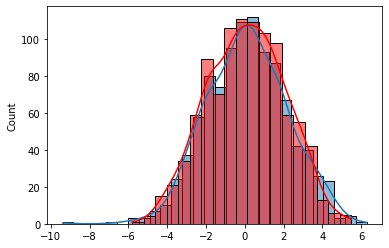

In [685]:
a = np.random.normal(0,2, 1000)
b = np.random.normal(0.,2, 1000)
c = np.random.normal(0.2,2, 1000)
sns.histplot(a, kde=True)
sns.histplot(b, kde=True, color='red')
r = stats.kstest(a,b )
print(r)

In [57]:
def SMD(a,b):
    pos_mean = np.mean(a)
    neg_mean = np.mean(b)
    pos_std  = np.std(a)
    neg_std  = np.std(b)
    smd = (pos_mean - neg_mean) / np.sqrt((pos_std ** 2 + neg_std ** 2) / 2)
    smd = abs(smd)
    return smd
SMD(instance_max_size, bbox_sizes)

0.0814838036945199

In [77]:
path_2_labels = {'yolov5':'/home/kirilman/Project/asbestos/yolov5/runs/detect/exp9/labels/',
                 'yolov6':'/home/kirilman/Project/asbestos/YOLOv6/runs/inference/exp/',
                 'yolov7':'/home/kirilman/Project/asbestos/yolov7/runs/detect/exp6/labels/'}

for model, path_2_label in path_2_labels.items():
    
    res_mannwhitneyu = {}
    result_smirnov   = {}
    smd_value        = {}
    for segment_file in get_paths_from_dirs(['../../../dataset/annotation/'],['json']):
        instance_max_size, img_names = get_instance_max_size(segment_file)
        bbox_sizes = get_bbox_size_arr(path_2_label, img_names)
        print("BBoxs :",len(bbox_sizes),'Segments:', len(instance_max_size), 'img:', len(img_names))
        r_wil = stats.mannwhitneyu(instance_max_size,bbox_sizes)
        res_mannwhitneyu[str(segment_file.parent).split('/')[-1]] = {'m_value': r_wil.statistic,'m_pvalue': r_wil.pvalue}
        r = stats.kstest(instance_max_size, bbox_sizes)
        result_smirnov[str(segment_file.parent).split('/')[-1]] =  {'s_value': r.statistic,'s_pvalue':r.pvalue}
        smd_value[str(segment_file.parent).split('/')[-1]] = {'smd': SMD(instance_max_size, bbox_sizes)}
        
    frame = pd.concat((pd.DataFrame(res_mannwhitneyu).T, pd.DataFrame(result_smirnov).T, pd.DataFrame(smd_value).T),
                        axis = 1)
    frame.to_csv(model + '.csv')
    frame = np.round(pd.DataFrame(frame), 4)
    frame.to_csv(model + '_round.csv')

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
2592 2048
BBoxs : 799 Segments: 718 img: 11
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
2592 2048
BBoxs : 378 Segments: 1521 img: 57
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
2592 2048
BBoxs : 994 Segments: 724 img: 13
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
2592 2048
BBoxs : 5688 Segments: 4531 img: 68
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
2592 2048
BBoxs : 239 Segments: 245 img: 24
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
2592 2048
BBoxs : 1760 Segments: 1382 img: 20
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
2592 2048
BBoxs : 1891 Segments: 2544 img: 134
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
2592 2048
BBoxs : 32

In [22]:
def get_bbox_size_arr(path_2_label, image_names = None):
    labels_files = get_paths_from_dirs([path_2_label],['txt'])
    if image_names:
        labels_files = list(filter(lambda x: True if str(x.name).split('.')[0] in image_names else False, labels_files))
    bbox_sizes = []
    for p in labels_files:
        data = np.loadtxt(p)
        if len(data.shape) > 1:
            bboxs = data[:,1:5]
        else:
            bboxs = data[1:5].reshape(1,-1)
        for i,box in enumerate(xywh2xyxy(bboxs)):
            bbox_sizes.append(get_diag(box))
    return np.array(bbox_sizes)

In [68]:
from dsatools.distances import *
from scipy.stats import wasserstein_distance
a = get_bbox_size_arr('../../yolov5/runs/detect/exp10/labels/')
b = get_bbox_size_arr('../../yolov5/runs/detect/exp9/labels/')
n = len(a)
print(len(a), len(b))
print(wasserstein_distance(a,b))

10858 14245
0.007184271119266155


In [63]:
r = {'a':5, 'b':3}
r['r'] = 2
r
a = np.array([5,2,3])
len(a)
np.sort(a)

array([2, 3, 5])